In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.types import FloatType,IntegerType

In [2]:
spark = SparkSession.builder.appName("AppRatingPredLinearRegression").config("spark.driver.memory", "8g").getOrCreate()
data=spark.read.load('googleplaystore.csv',format='csv',sep=',',header='true',escape='"',inferschema='true')

In [3]:
data.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



In [4]:
data=data.withColumn("Reviews",col("Reviews").cast(IntegerType()))\
.withColumn("Installs",regexp_replace(col("Installs"),"[^0-9]",""))\
.withColumn("Installs",col("Installs").cast(IntegerType()))\
.withColumn("Price",regexp_replace(col("price"),"[$]",""))\
.withColumn("Price",col("price").cast(FloatType()))\
.withColumn("Size",regexp_replace(col("Size"), "M", ""))\
.withColumn("Size", regexp_replace(col("Size"), "k", ""))\
.withColumn("Size", col("Size").cast(FloatType()))\
.withColumn('Size', regexp_replace(col('Size'), 'Varies with device', '0.0'))\
.withColumn('Size', col('Size').cast(FloatType()))

In [5]:
data.printSchema()
data = data.fillna(0)
data.columns

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Size: float (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)



['App',
 'Category',
 'Rating',
 'Reviews',
 'Size',
 'Installs',
 'Type',
 'Price',
 'Content Rating',
 'Genres',
 'Last Updated',
 'Current Ver',
 'Android Ver']

In [6]:
coef_var=['Installs','Reviews','Size']
assembler = VectorAssembler(inputCols=coef_var,
                           outputCol='features',handleInvalid="skip")
output=assembler.transform(data)
final_df=output.select('features','Rating')
final_df.show()

+--------------------+------+
|            features|Rating|
+--------------------+------+
|[10000.0,159.0,19.0]|   4.1|
|[500000.0,967.0,1...|   3.9|
|[5000000.0,87510....|   4.7|
|[5.0E7,215644.0,2...|   4.5|
|[100000.0,967.0,2...|   4.3|
|[50000.0,167.0,5....|   4.4|
|[50000.0,178.0,19.0]|   3.8|
|[1000000.0,36815....|   4.1|
|[1000000.0,13791....|   4.4|
|[10000.0,121.0,3....|   4.7|
|[1000000.0,13880....|   4.4|
|[1000000.0,8788.0...|   4.4|
|[1.0E7,44829.0,20.0]|   4.2|
|[100000.0,4326.0,...|   4.6|
|[100000.0,1518.0,...|   4.4|
|[5000.0,55.0,2.70...|   3.2|
|[500000.0,3632.0,...|   4.7|
| [10000.0,27.0,17.0]|   4.5|
|[5000000.0,194216...|   4.3|
|[1.0E7,224399.0,3...|   4.6|
+--------------------+------+
only showing top 20 rows



In [7]:
train_data, test_data = final_df.randomSplit([0.8,0.2],seed=1234)
train_data.describe().show()
test_data.describe().show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|              8681|
|   mean|3.6150097914986845|
| stddev| 1.521296372359405|
|    min|               0.0|
|    max|               5.0|
+-------+------------------+

+-------+-----------------+
|summary|           Rating|
+-------+-----------------+
|  count|             2160|
|   mean|3.656064814814815|
| stddev| 1.52312125457861|
|    min|              0.0|
|    max|             19.0|
+-------+-----------------+



In [8]:
train_data.show()
test_data.show()

+--------------------+------+
|            features|Rating|
+--------------------+------+
|           (3,[],[])|   0.0|
|[0.0,0.0,1.200000...|   0.0|
|[0.0,0.0,1.399999...|   0.0|
|[0.0,0.0,2.599999...|   0.0|
|[0.0,0.0,3.200000...|   0.0|
|[0.0,0.0,5.400000...|   0.0|
|       [0.0,0.0,5.5]|   0.0|
|[0.0,0.0,5.900000...|   0.0|
|[0.0,0.0,7.400000...|   0.0|
|[0.0,0.0,8.699999...|   0.0|
|      [0.0,0.0,10.0]|   0.0|
|      [0.0,0.0,33.0]|   0.0|
|      [0.0,0.0,40.0]|   0.0|
|      [0.0,0.0,56.0]|   0.0|
|       [1.0,0.0,0.0]|   0.0|
|       [1.0,0.0,0.0]|   0.0|
|       [1.0,0.0,0.0]|   0.0|
|[1.0,0.0,1.600000...|   0.0|
|[1.0,0.0,1.700000...|   0.0|
|[1.0,0.0,2.299999...|   0.0|
+--------------------+------+
only showing top 20 rows

+--------------------+------+
|            features|Rating|
+--------------------+------+
|           (3,[],[])|  19.0|
|[0.0,0.0,2.099999...|   0.0|
|[1.0,0.0,1.799999...|   0.0|
|[1.0,0.0,2.799999...|   0.0|
|[1.0,0.0,2.799999...|   0.0|
|[1.0,0.0,2.90

In [9]:
lm=LinearRegression(labelCol='Rating')
model=lm.fit(train_data)

In [10]:
import pandas as pd
pd.DataFrame({"Coefficients":model.coefficients}, index=coef_var)

,Coefficients
Installs,9.754780e-10
Reviews,2.316257e-08
Size,-2.798490e-04


In [11]:
res=model.evaluate(test_data)
res.residuals.show(5)

+-------------------+
|          residuals|
+-------------------+
| 15.401877959231157|
|-3.5975343578827763|
| -3.597618313546732|
|-3.5973384645406585|
|-3.5973384645406585|
+-------------------+
only showing top 5 rows



In [12]:
unlabeled_data=test_data.select('features')
predictions = model.transform(unlabeled_data)
predictions.select('prediction').show(5)
print(f"MSE:{res.meanSquaredError}")
print(f"MAE:{res.meanAbsoluteError}")
print(f"RMSE:{res.rootMeanSquaredError}")
print(f"R2:{res.r2}")

+------------------+
|        prediction|
+------------------+
|3.5981220407688417|
|3.5975343578827763|
| 3.597618313546732|
|3.5973384645406585|
|3.5973384645406585|
+------------------+
only showing top 5 rows

MSE:2.302158065516382
MAE:1.0786574575130905
RMSE:1.5172864151228607
R2:0.007187376553973057


In [13]:
test_pd=test_data.select('Rating').toPandas()
pred_test_pd=predictions.select('prediction').toPandas()

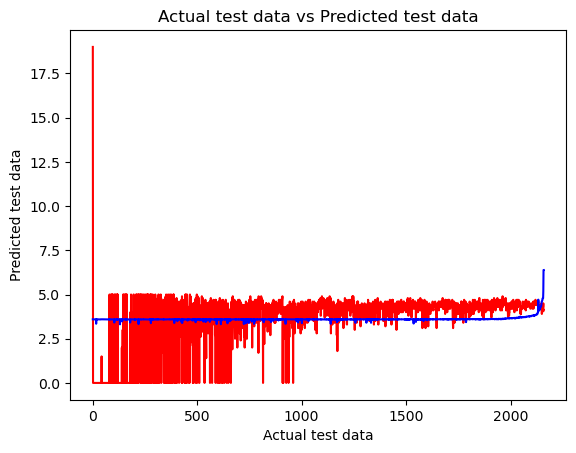

In [14]:
import matplotlib.pyplot as plt
plt.plot(test_pd['Rating'],color='red')
plt.plot(pred_test_pd['prediction'],color='blue')
plt.xlabel('Actual test data')
plt.ylabel('Predicted test data')
plt.title('Actual test data vs Predicted test data')
plt.show()